Adapted from this Kernel
https://www.kaggle.com/ecobill/u-nets-with-keras

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from tensorflow.keras.layers import Dense, Conv2D, Input, MaxPool2D, UpSampling2D, Concatenate, Conv2DTranspose
from tensorflow.keras import Sequential,Model
from tensorflow.keras.losses import BinaryCrossentropy
import tensorflow as tf
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import cv2
import os
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator


In [25]:
data_dir = 'G:/Github/Caravan_challenge/data/train/'
mask_dir = 'G:/Github/Caravan_challenge/data/train_masks/'
test_dir = 'G:/Github/Caravan_challenge/data/test/'
all_images = os.listdir(data_dir)
image_size = 224

In [6]:
len(all_images)

5088

In [3]:
train_images, validation_images = train_test_split(all_images, train_size=0.8, test_size=0.2)

In [4]:
# utility function to convert greyscale images to rgb
def grey2rgb(img):
    new_img = []
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            new_img.append(list(img[i][j])*3)
    new_img = np.array(new_img).reshape(img.shape[0], img.shape[1], 3)
    return new_img

In [28]:
# generator that we will use to read the data from the directory
def data_gen_small(data_dir, mask_dir, images, batch_size, dims):
        """
        data_dir: where the actual images are kept
        mask_dir: where the actual masks are kept
        images: the filenames of the images we want to generate batches from
        batch_size: self explanatory
        dims: the dimensions in which we want to rescale our images, tuple
        """
        while True:
            ix = np.random.choice(np.arange(len(images)), batch_size)
            imgs = []
            labels = []
            for i in ix:
                # images
                original_img = load_img(data_dir + images[i])
                resized_img = original_img.resize(dims)
                array_img = img_to_array(resized_img)/255
                imgs.append(array_img)
                
                # masks
                original_mask = load_img(mask_dir + images[i].split(".")[0] + '_mask.gif')
                resized_mask = original_mask.resize(dims)
                array_mask = img_to_array(resized_mask)/255
                labels.append(array_mask[:, :, 0])
            imgs = np.array(imgs)
            labels = np.array(labels)
            yield imgs, labels.reshape(-1, dims[0], dims[1], 1)

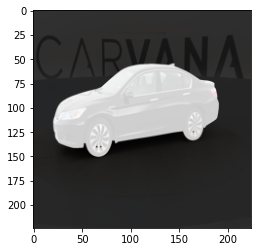

In [36]:
train_gen = data_gen_small(data_dir, mask_dir, train_images, 5, (image_size, image_size))
img, msk = next(train_gen)

plt.imshow(img[0])
plt.imshow(grey2rgb(msk[0]), alpha=0.8)

Define down and up layers in Unet

In [7]:
def down(input_layer, filters, pool=True):
    conv1 = Conv2D(filters, (3, 3), padding='same', activation='relu')(input_layer)
    residual = Conv2D(filters, (3, 3), padding='same', activation='relu')(conv1)
    if pool:
        max_pool = MaxPool2D()(residual)
        return max_pool, residual
    else:
        return residual

In [8]:
def up(input_layer, residual, filters):
    filters=int(filters)
    upsample = UpSampling2D()(input_layer)
    upconv = Conv2D(filters, kernel_size=(2, 2), padding="same")(upsample)
    concat = Concatenate(axis=3)([residual, upconv])
    conv1 = Conv2D(filters, (3, 3), padding='same', activation='relu')(concat)
    conv2 = Conv2D(filters, (3, 3), padding='same', activation='relu')(conv1)
    return conv2

In [31]:
# Make a custom U-nets implementation.
filters = 64
input_layer = Input(shape = [image_size, image_size, 3])
layers = [input_layer]
residuals = []

# Down 1, 128
d1, res1 = down(input_layer, filters)
residuals.append(res1)

filters *= 2

# Down 2, 64
d2, res2 = down(d1, filters)
residuals.append(res2)

filters *= 2

# Down 3, 32
d3, res3 = down(d2, filters)
residuals.append(res3)

filters *= 2

# Down 4, 16
d4, res4 = down(d3, filters)
residuals.append(res4)

filters *= 2

# Down 5, 8
d5 = down(d4, filters, pool=False)

# Up 1, 16
up1 = up(d5, residual=residuals[-1], filters=filters/2)
filters /= 2

# Up 2,  32
up2 = up(up1, residual=residuals[-2], filters=filters/2)

filters /= 2

# Up 3, 64
up3 = up(up2, residual=residuals[-3], filters=filters/2)

filters /= 2

# Up 4, 128
up4 = up(up3, residual=residuals[-4], filters=filters/2)

out = Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid")(up4)

model = Model(input_layer, out)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 224, 224, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 224, 224, 64) 36928       conv2d_23[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 112, 112, 64) 0           conv2d_24[0][0]                  
____________________________________________________________________________________________

In [35]:
# Now let's use Tensorflow to write our own dice_coeficcient metric
def dice_coef(y_true, y_pred):
    smooth = 1e-5
    
    y_true = tf.round(tf.reshape(y_true, [-1]))
    y_pred = tf.round(tf.reshape(y_pred, [-1]))
    
    isct = tf.reduce_sum(y_true * y_pred)
    
    return 2 * isct / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred))

In [34]:
model.compile(optimizer = 'Adam', loss = BinaryCrossentropy(), metrics=['accuracy',dice_coef])

Train the model

In [ ]:
model.fit(train_gen, 
                    steps_per_epoch=212, 
                    epochs=24)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 212 steps
Epoch 1/24
212/212 [==============================] - 1503s 7s/step - loss: 1.1560 - accuracy: 0.8240 - dice_coef: 0.3750
Epoch 2/24
 49/212 [=====>........................] - ETA: 18:50 - loss: 0.3521 - accuracy: 0.8655 - dice_coef: 0.6120